In [1]:
import pandas as pd
import numpy as np

In [2]:
from collections import Counter

# Etude protocole 2 classification
Dans ce notebook, nous voulons prédire si un individu sera endetté dans le futur

In [3]:
df = pd.read_csv('../Clean_Dataset/df_protocole_2_lessNans.csv', low_memory=False, index_col=0)

In [4]:
df['solde_std_0'].isna().sum()

593

## réduction du nombre de variables utilisées
Pour le moment, nous souhaitons utiliser les données numériques non catégorielles.
Nous avons donc éliminé le code postal du dataset

In [5]:
menage_features = [c for c in df.columns if not c[-1].isdigit()]

In [6]:
df_numerical_menage_features = df[menage_features]._get_numeric_data()
numerical_menage_features = list(df_numerical_menage_features.columns.values)
numerical_menage_features.remove('nan_solde_count')
numerical_menage_features.remove('individu_id')
numerical_menage_features.remove('geo_cp')



In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

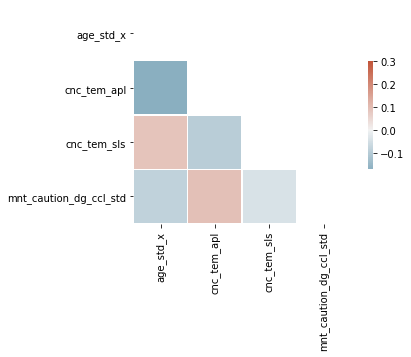

In [8]:
fig, ax = plt.subplots()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = df[numerical_menage_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [9]:
df_temp_numerical = df[[c for c  in df.columns if c not in menage_features]]._get_numeric_data()

In [10]:
temp_numerical_features = df_temp_numerical.columns

<AxesSubplot:>

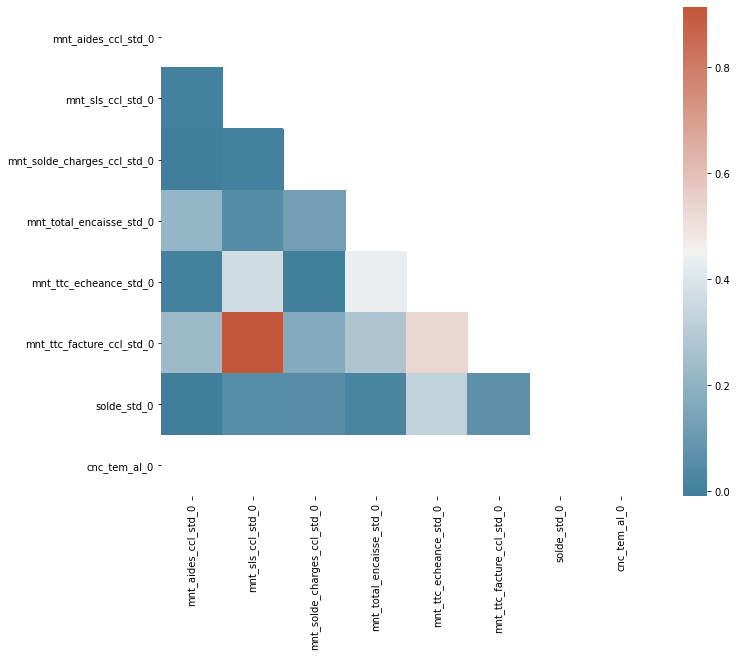

In [11]:
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = df_temp_numerical[[c for c in df_temp_numerical if '_0' in c]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap)

#### Fonctions pour selectionner les variables historiques

In [12]:
## selection des mois de -n à -k

def get_str_num(s) -> int:
    """returns the number at the end of a string"""
    n = s.split('_')[-1]
    if n[-1].isdigit():
        return int(n)
    

def get_feature_and_months_col(columns: list, m_min: int, m_max: int, target: str=None)->list:
    """
    returns the columns used in the history for the prediction
    i.e. information between month m_min and month m_max
    if the target is added, the target column is also returned.
    """
    assert m_min <= m_max, 'the first month should be smaller than the last'
    if target:
        features = [c for c in columns if c==target or get_str_num(c)!=None and m_min<=get_str_num(c)<=m_max ]
    else:
        features = [c for c in columns if get_str_num(c)!=None and m_min<=get_str_num(c)<=m_max ]
    return features
    

    

In [13]:
def is_in_debt(df: pd.DataFrame, month:int=1) -> pd.Series: 
    """
    function to determine if an individual is indebted by the month 'month'
    this column will be used as the target to predict
    """
    #assert month>0, "We want to predict the debt in the future: please choose month>0"
    assert f'solde_std_{month}' in df.columns.values
    assert f'solde_std_{month-1}' in df.columns.values
    assert f'mnt_ttc_echeance_std_{month-1}' in df.columns.values
    assert f'mnt_ttc_echeance_std_{month-2}' in df.columns.values
    
    rows_with_nan = (df[f"solde_std_{month}"] 
                     + df[f'mnt_ttc_echeance_std_{month-1}']
                     + df[f"solde_std_{month-1}"]
                     + df[f'mnt_ttc_echeance_std_{month-2}']
                    ).isna()

    
    is_in_debt_col = (
        (df[f"solde_std_{month}"]>df[f'mnt_ttc_echeance_std_{month-1}']/2)
        & (df[f"solde_std_{month-1}"]>df[f'mnt_ttc_echeance_std_{month-2}']/2)
    )


    is_in_debt_col[rows_with_nan] = np.nan
    return is_in_debt_col

is_in_debt(df_temp_numerical, 3)

0       0.0
1       1.0
2       0.0
3       0.0
4       0.0
       ... 
8220    NaN
8221    NaN
8222    NaN
8223    NaN
8224    NaN
Length: 147934, dtype: float64

### fonction pour choisir les individus qui seront utilisés pour l'entrainement d'un modèle

In [14]:
def get_individuals(df:pd.DataFrame, nb_past_months:int, future_month:int):
    """
    this function get the data set with unique individuals, 
    their hitory of lenght nb_past_months
    and their target future_month
    """
    in_debt = is_in_debt(df, future_month)
    history = get_feature_and_months_col(columns=df.columns.values, m_min=-nb_past_months+1, m_max=0)
    #print(len((~in_debt.isna()).tolist()))
    df_individuals = df.loc[(~in_debt.isna()).tolist(),history + menage_features]
    df_individuals[f'in_debt_{future_month}'] = in_debt.loc[(~in_debt.isna()).tolist(),]

    df_individuals.dropna(
        axis='index',
        #how='any',
        thresh=len(history)-1,
        subset=history,
        inplace=True
    )
    df_individuals.drop_duplicates(
        subset="individu_id",
        inplace=True
    )
    return df_individuals

## traitement des données manquantes

In [15]:
df_past_numerical_data = get_individuals(df, nb_past_months=3, future_month=3)
df_past_numerical_data = df_past_numerical_data._get_numeric_data()

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [17]:
target = 'in_debt_3'
categorical = ['geo_cp']
features = [c for c in df_past_numerical_data.columns if c not in set(
    [target, 'individu_id','nan_solde_count']+categorical
)]
X = df_past_numerical_data[features]
y = df_past_numerical_data[target]

In [18]:
imp = IterativeImputer(max_iter=10, random_state=0)
X_imp = imp.fit_transform(X)

### partage des données entre train et test set

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.33, random_state=42)


### calculs des scores de baseline

accuracy score: 0.9240972733971997


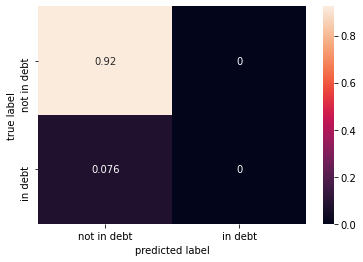

In [21]:
# base line y_pred = 0

y_base = np.zeros_like(y_test)
def confusion_matrix_and_acc(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(
        cm/len(y_base), 
        index = [i for i in ['not in debt', 'in debt']],
        columns = [i for i in ['not in debt', 'in debt']]
    )
    print(f"accuracy score: {accuracy_score(y_test, y_pred)}")
    fig, ax = plt.subplots()
    ax = sns.heatmap(df_cm, annot=True)
    ax.set_xlabel("predicted label")
    ax.set_ylabel("true label")
confusion_matrix_and_acc(y_test, y_base)

set()
accuracy score: 0.8253500368459837


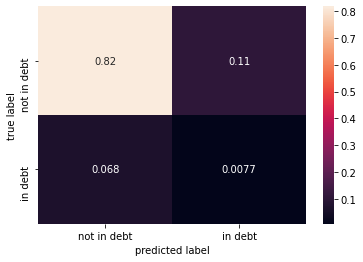

In [22]:
# base line y_pred = inbebt now
m = X[f"solde_std_0"]>X[f'mnt_ttc_echeance_std_-1']/2

print(set(y_test.index) - set(m.index))
#m['index_1'] = df.index
y_base = m.loc[(m.index.isin(set(y_test.index.tolist())))]
confusion_matrix_and_acc(y_test, y_base)

## entrainement des modèles

### regression logistique
Nous utilisons un pipe avec la normalisation pour permetre une convergeance plus rapide du resolver

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler #faster convergence for log reg
from sklearn.linear_model import LogisticRegression

In [24]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

/home/pier/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [25]:
logreg_l2_pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2'))
logreg_l2_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

accuracy score: 0.9602063375092115


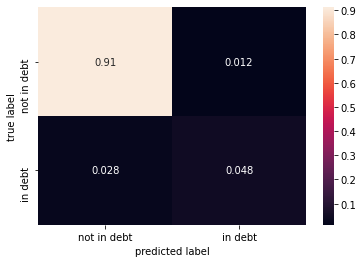

In [26]:
y_pred = logreg_l2_pipe.predict(X_test)
confusion_matrix_and_acc(y_test, y_pred>0.5)

In [27]:
from sklearn.pipeline import Pipeline

accuracy score: 0.9594694178334562


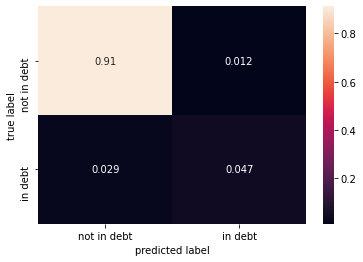

In [28]:
logreg_l1_pipe = Pipeline(
    steps=[('scaling',StandardScaler()), 
           ('logreg', LogisticRegression(penalty='l1', solver="saga"))
          ]
)
logreg_l1_pipe.fit(X_train, y_train)
y_pred = logreg_l1_pipe.predict(X_test)
confusion_matrix_and_acc(y_test, y_pred>0.5)

In [29]:
df_lasso_coefs = pd.DataFrame(
data={
    "columns": list(X.columns.values),
    "_coefs": list(logreg_l1_pipe.named_steps['logreg'].coef_.reshape(-1,))
})
lasso_cols = df_lasso_coefs[np.abs(df_lasso_coefs._coefs)>0.005]['columns'].unique()

min_coef = 0
if "individu_id" in df_lasso_coefs['columns'].values:
    min_coef = abs(df_lasso_coefs.loc[df_lasso_coefs['columns']=='individu_id','_coefs'].values[0])
df_lasso_coefs[np.abs(df_lasso_coefs._coefs)>min_coef].sort_values(
    by='_coefs',
    ascending=False,
    key=abs
)

,columns,_coefs
14,solde_std_-1,1.716949
6,solde_std_0,1.190216
3,mnt_total_encaisse_std_0,-0.955476
21,solde_std_-2,0.856875
11,mnt_total_encaisse_std_-1,-0.787211
18,mnt_total_encaisse_std_-2,-0.468223
26,mnt_caution_dg_ccl_std,0.442460
19,mnt_ttc_echeance_std_-2,0.385661
4,mnt_ttc_echeance_std_0,0.349192
0,mnt_aides_ccl_std_0,0.348092


In [30]:
month_nb = set()
titles = set()
for col in lasso_cols:
    words = col.split('_')
    month = words[-1]
    try:
        month = int(month)
        month_nb.add(month)
        titles.add('_'.join(words[:-1]))
    except ValueError as e:
        pass

In [31]:
df_for_plt = pd.DataFrame(data={
    'title': [tout for t in titles for tout in [t]*len(month_nb)],
    'month': [i for _ in [0]*len(titles) for i in np.arange(len(month_nb))*(-1) ],
    'coef': [
        df_lasso_coefs[df_lasso_coefs['columns']==t+'_'+str(m)]['_coefs'].values[0]
        for t in titles 
        for m in reversed(sorted([int(y) for y in month_nb]))
    ]
})

<AxesSubplot:xlabel='month', ylabel='coef'>

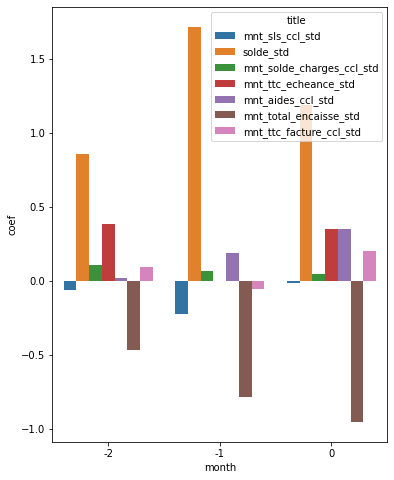

In [32]:
fig, ax = plt.subplots(figsize=(6,8))
sns.barplot(data=df_for_plt, hue='title', x='month', y='coef', ci=None)

#### Est-ce que la PCA améloire la précision ? 

In [33]:
from sklearn.decomposition import PCA

accuracy score: 0.9598378776713338


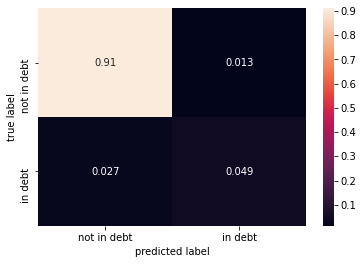

In [34]:
pipe = Pipeline(
    steps=[('pca',PCA(n_components=10)), 
           ('logreg', LogisticRegression())
          ]
)
reg = pipe.fit(X_train, y_train)
y_pred = reg.predict(X_test)
confusion_matrix_and_acc(y_test, y_pred>0.5)

### KNN

le classifieur avec les k plus proches voisins fonctionne mieux lorque le nombre de variables reste faible. Il est donc interessant d'appliquer une PCA avant d'entrainer le modèle KNN.

In [35]:
from sklearn.neighbors import KNeighborsClassifier

#### optimisation sur le nombre de composants

In [36]:
accuracies = []
r = range(1,len(X.columns.values),4)
for n in r:
    knn_pipe = Pipeline(
    steps=[('pca',PCA(n_components=n)), 
           ('knn', KNeighborsClassifier())
          ]
    )
    knn = knn_pipe.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

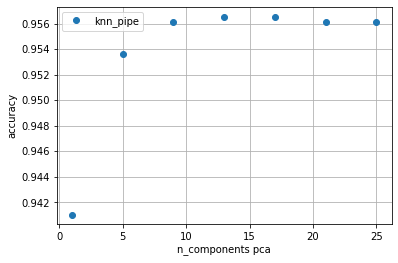

In [37]:
fig, ax = plt.subplots()
ax.plot(r, accuracies, 'o', label='knn_pipe')
ax.set_xlabel('n_components pca')
ax.set_ylabel('accuracy')
plt.grid(True)
plt.legend()

On va donc choisir 9 comme nombre de composants pour faire la PCA avant l'entrainement du modèle knn

#### Optimisation sur le nombre de voisins

In [38]:
accuracies = []
r = range(1,25,4)
for n in r:
    knn_pipe = Pipeline(
    steps=[('pca',PCA(n_components=9)), 
           ('knn', KNeighborsClassifier(n_neighbors=n, weights='distance'))
          ]
    )
    knn = knn_pipe.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

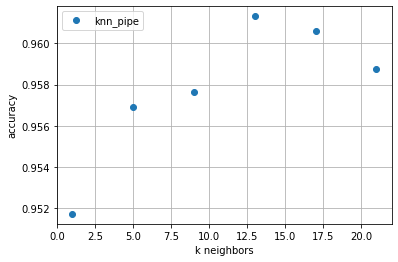

In [39]:
fig, ax = plt.subplots()
ax.plot(r, accuracies, 'o', label='knn_pipe')
ax.set_xlabel('k neighbors')
ax.set_ylabel('accuracy')
plt.grid(True)
plt.legend()

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
parameters = {"pca__n_components":[5,len(X.columns.values)], "knn__n_neighbors":[1,30]}
grid = GridSearchCV(knn_pipe, parameters)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA(n_components=9)),
                                       ('knn',
                                        KNeighborsClassifier(n_neighbors=21,
                                                             weights='distance'))]),
             param_grid={'knn__n_neighbors': [1, 30],
                         'pca__n_components': [5, 27]})

accuracy score: 0.9583640383198231


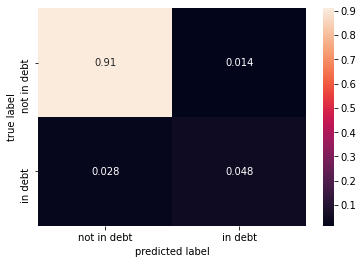

In [42]:
knn_pipe = Pipeline(
    steps=[('pca',PCA(n_components=9)), 
           ('logreg', KNeighborsClassifier(n_neighbors=24, weights='distance'))
          ]
)
knn = knn_pipe.fit(X_train, y_train)
y_pred = knn.predict(X_test)
confusion_matrix_and_acc(y_test, y_pred>0.5)

### arbre de decision

In [43]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

accuracy score: 0.9513633014001474


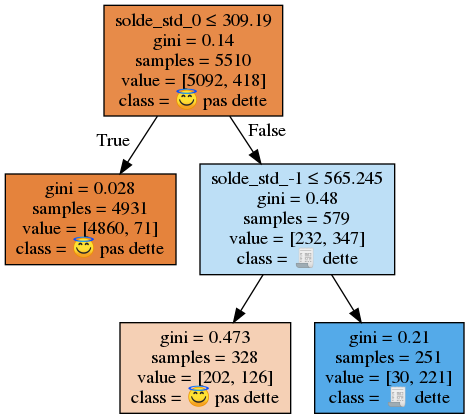

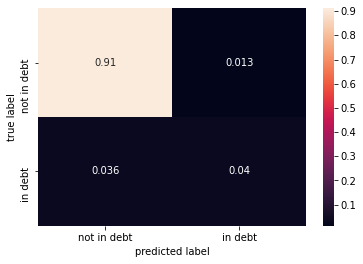

In [44]:
dot_data = StringIO()
alpha = 0.005
tree_clf = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
tree_clf.fit(X_train, y_train)
export_graphviz(
    tree_clf, 
    out_file=dot_data,  
    filled=True,
    special_characters=True,
    feature_names = X.columns,
    class_names=['😇 pas dette','🧾 dette']
    )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(f'decision_tree_a{alpha}_dette.png')
#print(clf.score(X_test, y_test))
y_pred = tree_clf.predict(X_test)
confusion_matrix_and_acc(y_test, y_pred>0.5)
Image(graph.create_png())

#### roc curves

In [45]:
from sklearn.metrics import plot_roc_curve

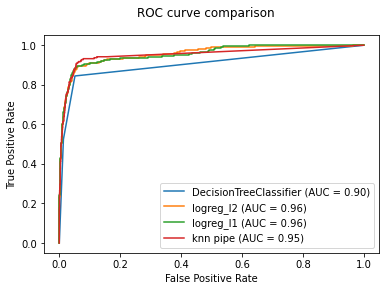

In [47]:
tree_disp = plot_roc_curve(tree_clf, X_test, y_test)
logregl1_disp = plot_roc_curve(logreg_l1_pipe, X_test, y_test, ax=tree_disp.ax_, name='logreg_l2')
logregl2_disp = plot_roc_curve(logreg_l2_pipe, X_test, y_test, ax=tree_disp.ax_, name='logreg_l1')
knn_disp = plot_roc_curve(knn_pipe, X_test, y_test, ax=tree_disp.ax_, name='knn pipe')
tree_disp.figure_.suptitle("ROC curve comparison")
plt.show()

In [80]:
def future_month_accuracies(clf, df, nb_past_months:int, m_min: int, m_max: int):
    assert m_min > 0, "we want to predict future months"
    assert m_max>= m_min, "the last month should be after the first"
    accuracies = {}
    for month in range(m_min, m_max+1):
        df_individuals = get_individuals(df, nb_past_months, month)._get_numeric_data()
        
        #deal with missing values
        target = f'in_debt_{month}'
        features = [c for c in df_individuals.columns if c not in set(
            [target, 'individu_id','nan_solde_count']+categorical
        )]
        X = df_individuals[features]
        y = df_individuals[target]
        imp = IterativeImputer(max_iter=10, random_state=0)
        if len(X)<=20:
            continue
        X_imp = imp.fit_transform(X)
        
        #split data
        X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.33, random_state=42)
            
        #train
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies[month] = accuracy_score(y_test, y_pred)
        
    return accuracies

pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2'))
future_month_accuracies(pipe, df, nb_past_months=3, m_min=1, m_max=2)

{1: 0.9812154696132597, 2: 0.96353591160221}

## graph de la précision en fonction du nombre de mois en historique

In [81]:
accuracies = []
max_history = 11
pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2'))
for nb_months in range(1, max_history):
    acc = future_month_accuracies(
        pipe, df, nb_past_months=nb_months, m_min=3, m_max=3
    )
    accuracies.append(acc.get(3))
    


Text(0, 0.5, 'accuracy')

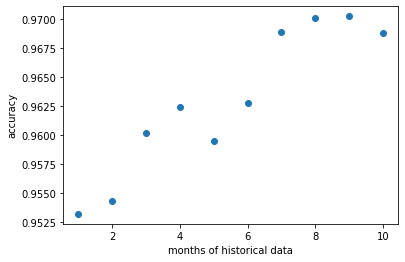

In [82]:
fig, ax = plt.subplots()
ax.plot(range(1,max_history), accuracies, "o")
ax.set_xlabel("months of historical data")
ax.set_ylabel("accuracy")

7 mois d'historique semble donc suffisant pour prédire si un individu sera en dette dans 3 mois

In [83]:
y_zeros = np.zeros_like(y_test)
y_last = m.loc[(m.index.isin(set(y_test.index.tolist())))]

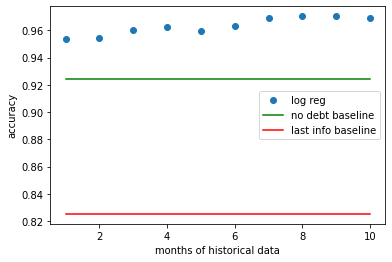

In [84]:
fig, ax = plt.subplots()
x = range(1,max_history)
ax.plot(x, accuracies, "o", label="log reg")
ax.plot(x, [accuracy_score(y_test, y_zeros)]*len(x), "g", label="no debt baseline")
ax.plot(x, [accuracy_score(y_test, y_last)]*len(x), "r", label="last info baseline")
ax.set_xlabel("months of historical data")
ax.set_ylabel("accuracy")
plt.legend()

## graph de la précision en fonction du mois 

In [85]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2'))
accuracies = future_month_accuracies(
    pipe, df, nb_past_months=7, m_min=1, m_max=15
)

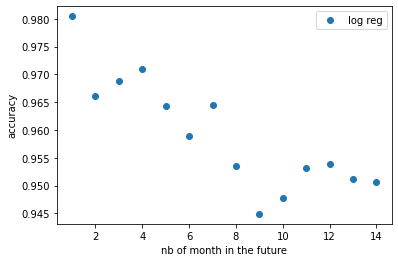

In [86]:
fig, ax = plt.subplots()
month, acc = zip(*accuracies.items())
ax.plot(month, acc, "o", label='log reg')
ax.set_xlabel("nb of month in the future")
ax.set_ylabel("accuracy")
plt.legend()